<a href="https://colab.research.google.com/github/GeorgeJB3/NYC-Taxi-Trip-Data-Analysis/blob/main/NYC_taxi_trips_George_Baldwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Taxi trips

This project is to analyse NYC taxi trips from September 2024 to December 2024. I got the data from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page using only the Yellow Taxi Trip Records.

### Ingestion

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Urls for yellow taxi trip record parquet files

In [ ]:
september_file = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-09.parquet"
october_file = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-10.parquet"
november_file = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-11.parquet"
december_file = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-12.parquet"

In [ ]:
# Add parquet links into a list to iterate through them on the next step
taxi_trip_files = [september_file, october_file,november_file,december_file]

# Read all the parquet files and create a dataframe with all the required data
df_list = [pd.read_parquet(file) for file in taxi_trip_files]
staging_df = pd.concat(df_list, ignore_index=True)

### Cleaning and transform stage

In [ ]:
# Create a new dataframe to begin the cleaning and transforming process. Remove rows with NULL values
df_clean = staging_df.dropna()

In [ ]:
# Filter out negative or zero fares
df_clean = df_clean[df_clean['fare_amount'] > 0]

# Filter out negative or zero distances or greater than 50
df_clean = df_clean[(df_clean['trip_distance'] > 0) & (df_clean['trip_distance'] <= 50)]

# Set datetime columns to datetime datatypes
df_clean['tpep_pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'], errors='coerce')
df_clean['tpep_dropoff_datetime'] = pd.to_datetime(df_clean['tpep_dropoff_datetime'], errors='coerce')

# A separate dataframe to trips that have invalid droff and pick up times for investigations
invalid_journey_times = df_clean[df_clean['tpep_dropoff_datetime'] <= df_clean['tpep_pickup_datetime']].copy()

# Remove rows where dropoff is before pickup
df_clean = df_clean[df_clean['tpep_dropoff_datetime'] > df_clean['tpep_pickup_datetime']]

# Create new column for trip duration and format value to only have hour, minute and second
df_clean["trip_duration_minutes"] = (df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']).dt.total_seconds() / 60
df_clean["trip_duration_minutes"] = df_clean["trip_duration_minutes"].round(0)

# Create colums for hour of the day and day of the week
df_clean["Pick_up_time_(hour)"] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean["day_of_the_week"] = df_clean['tpep_pickup_datetime'].dt.day_name()

# Create trip_category column to show short, medium and long trips
df_clean["trip_category"] = pd.cut(df_clean["trip_distance"], bins=[0, 5, 10, 50], labels=["short", "medium", "long"])

In [ ]:
print(df_clean.head(5))

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2024-09-01 00:05:51   2024-09-01 00:45:03              1.0   
1         1  2024-09-01 00:59:35   2024-09-01 01:03:43              1.0   
2         2  2024-09-01 00:25:00   2024-09-01 00:34:37              2.0   
3         2  2024-09-01 00:31:00   2024-09-01 00:46:52              1.0   
4         2  2024-09-01 00:11:57   2024-09-01 00:30:41              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           9.80         1.0                  N           138            48   
1           0.50         1.0                  N           140           141   
2           2.29         1.0                  N           238           152   
3           5.20         1.0                  N            93           130   
4           2.26         1.0                  N            79           231   

   payment_type  ...  tip_amount  tolls_amount  improvement_surcharge  \
0

## Aggregation and Analysis:

In [ ]:
trip_duration_analysis = pd.DataFrame({
    "mean": [round(df_clean["trip_duration_minutes"].mean(), 1)],
    "median": [round(df_clean["trip_duration_minutes"].median(), 1)],
    "max": [round(df_clean["trip_duration_minutes"].max(), 1)],
    "min": [round(df_clean["trip_duration_minutes"].min(), 1)]
})

fare_amount_analysis = pd.DataFrame({
    "mean": [round(df_clean["fare_amount"].mean(), 1)],
    "median": [round(df_clean["fare_amount"].median(), 1)],
    "max": [round(df_clean["fare_amount"].max(), 1)],
    "min": [round(df_clean["fare_amount"].min(), 1)]
})

trip_distance_analysis = pd.DataFrame({
    "mean": [round(df_clean["trip_distance"].mean(), 1)],
    "median": [round(df_clean["trip_distance"].median(), 1)],
    "max": [round(df_clean["trip_distance"].max(), 1)],
    "min": [round(df_clean["trip_distance"].min(), 1)]
})

In [ ]:
print(trip_duration_analysis.head(10))
print(fare_amount_analysis.head(10))
print(trip_distance_analysis.head(10))

   mean  median     max  min
0  18.5    14.0  9757.0  0.0
   mean  median       max  min
0  20.2    14.2  335544.4  0.0
   mean  median   max  min
0   3.4     1.7  50.0  0.0


In [ ]:
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean['pickup_day'] = df_clean['tpep_pickup_datetime'].dt.day_name()

In [ ]:
trips_groupby_day = df_clean.groupby("pickup_day").size().reset_index(name="total_trips")
trips_groupby_hour = df_clean.groupby("pickup_hour").size().reset_index(name="total_trips")

In [ ]:
avg_fare_per_day = df_clean.groupby("pickup_day")["fare_amount"].mean().reset_index(name="avg_fare_per_day")
avg_fare_per_day["avg_fare_per_day"] = avg_fare_per_day["avg_fare_per_day"].round(2)

avg_fare_per_hour = df_clean.groupby("pickup_hour")["fare_amount"].mean().reset_index(name="avg_fare_per_hour")
avg_fare_per_hour["avg_fare_per_hour"] = avg_fare_per_hour["avg_fare_per_hour"].round(2)

avg_duration_per_day = df_clean.groupby("pickup_day")["trip_duration_minutes"].mean().reset_index(name="avg_duration_per_day")
avg_duration_per_day["avg_duration_per_day"] = avg_duration_per_day["avg_duration_per_day"].round(2)

avg_duration_per_hour = df_clean.groupby("pickup_hour")["trip_duration_minutes"].mean().reset_index(name="avg_duration_per_hour")
avg_duration_per_hour["avg_duration_per_hour"] = avg_duration_per_hour["avg_duration_per_hour"].round(2)

In [ ]:
print(avg_fare_per_day.head(5))
print(avg_fare_per_hour.head(5))
print(avg_duration_per_day.head(5))
print(avg_duration_per_hour.head(5))

  pickup_day  avg_fare_per_day
0     Friday             20.03
1     Monday             21.11
2   Saturday             19.07
3     Sunday             21.06
4   Thursday             20.35
   pickup_hour  avg_fare_per_hour
0            0              19.95
1            1              17.46
2            2              15.80
3            3              17.14
4            4              23.60
  pickup_day  avg_duration_per_day
0     Friday                 18.53
1     Monday                 18.72
2   Saturday                 17.49
3     Sunday                 17.54
4   Thursday                 19.43
   pickup_hour  avg_duration_per_hour
0            0                  15.55
1            1                  14.15
2            2                  12.78
3            3                  12.59
4            4                  14.89


## Reporting/Predicting & Visualisation:

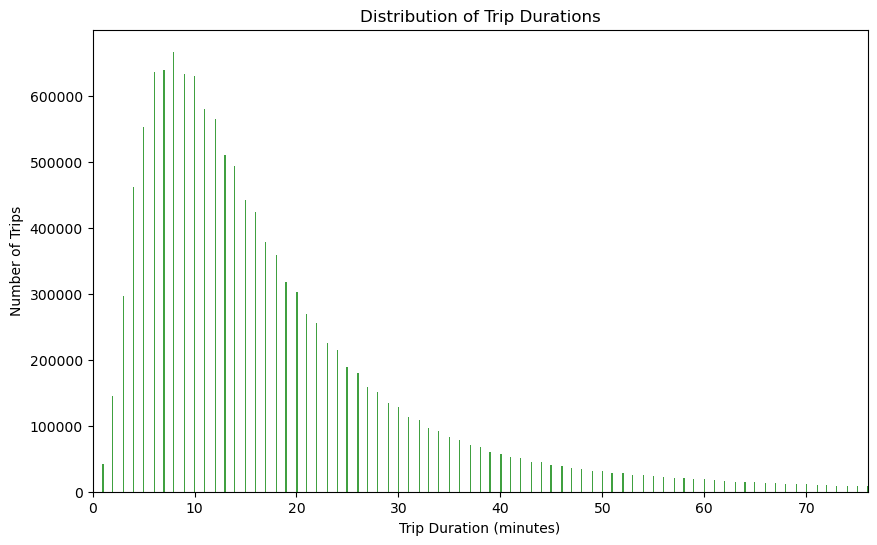

In [ ]:
# The xlim(0, dataframe.quantile(0.99))only selects the duration in which 99% of the results are within.
# Avoiding outliers to show a more accurate representation
plt.figure(figsize=(10,6))
sns.histplot(df_clean['trip_duration_minutes'], color='green')
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.xlim(0, df_clean['trip_duration_minutes'].quantile(0.99))
plt.show()

In [ ]:
# Create dataframe for all of decemeber 2024 data
december_data = df_clean[(df_clean['tpep_pickup_datetime'].dt.year == 2024) & (df_clean['tpep_pickup_datetime'].dt.month == 12)].copy()

In [ ]:
# Extract the hour and day from pickup datetime
december_data['pickup_hour'] = december_data['tpep_pickup_datetime'].dt.hour
december_data['pickup_day'] = december_data['tpep_pickup_datetime'].dt.day_name()

# Order the days for plotting the graph
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
december_data['pickup_day'] = pd.Categorical(december_data['pickup_day'], categories=day_order, ordered=True)

# Group by day and hour to get the trip counts
trip_counts = december_data.groupby(['pickup_day', 'pickup_hour']).size().reset_index(name='trip_count')

# Pivot for heatmap using the number of trips for values and days/hours for the axis
trip_pivot = trip_counts.pivot(index='pickup_day', columns='pickup_hour', values='trip_count')

/var/folders/fh/g7hmdltn5tdgt_jg6syvcnbw0000gp/T/ipykernel_8304/2951545390.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_counts = december_data.groupby(['pickup_day', 'pickup_hour']).size().reset_index(name='trip_count')


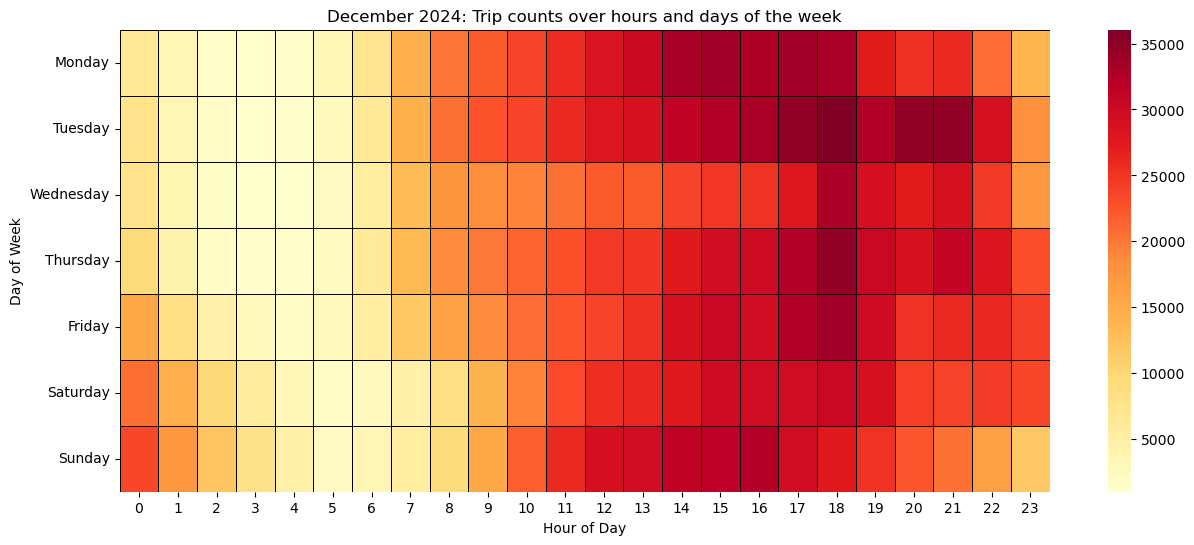

In [ ]:
# Heatmap to show which hours and days have the most or least taxi trips
plt.figure(figsize=(15,6))
sns.heatmap(trip_pivot, cmap='YlOrRd', linewidths=0.5, linecolor='black')
plt.title('December 2024: Trip counts over hours and days of the week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

In [ ]:
# Group by hour and calculate average fare
avg_fare_per_hour_during_december_24 = december_data.groupby('pickup_hour')['fare_amount'].mean().reset_index()

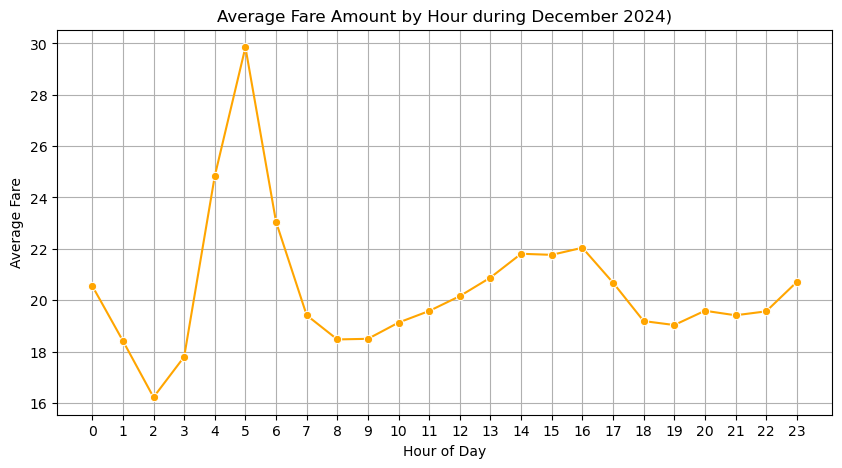

In [ ]:
# Plotting a graph to show average fare per hour during a 24 hour period
plt.figure(figsize=(10,5))
sns.lineplot(data=avg_fare_per_hour_during_december_24, x='pickup_hour', y='fare_amount', marker='o', color='orange')
plt.title('Average Fare Amount by Hour during December 2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## How I would scale and optimise this code to include data all the way from 2009

In [ ]:
Automation

In [ ]:
Data Warehouse

In [ ]:
Data Modelling